# PIL library

In [4]:
from PIL import Image
import numpy as np

Just looking at colored pixels:
http://stackoverflow.com/questions/18035046/how-to-compute-colored-pixel-area-on-images-using-python

In [5]:
img = np.asarray(Image.open("topview.jpg").convert('L'))
img = 1 * (img < 127)

m,n = img.shape

# use np.sum to count white pixels
print("{} white pixels, out of {} pixels in total.".format(img.sum(), m*n))

# use slicing to count any sub part, for example from rows 300-320 and columns 400-440
print("{} white pixels in rectangle.".format(img[300:320,400:440].sum()))

461063 white pixels, out of 15872256 pixels in total.
0 white pixels in rectangle.


Finding outlines
http://stackoverflow.com/questions/9319767/image-outline-using-python-pil

In [7]:
from PIL import ImageFilter

image = Image.open('topview.jpg')
image = image.filter(ImageFilter.FIND_EDGES)
image.save('topview_edges.jpg') 

PIL library tutorial: http://pillow.readthedocs.io/en/latest/handbook/tutorial.html

In [12]:
print(image.format, image.size, image.mode)

None (5312, 2988) RGB


# scikit-image library
http://scikit-image.org/<br>
pip install scikit-image 

In [5]:
from skimage import data, io, filters
import numpy as np

In [13]:
picture = io.imread("topview.jpg")
picture.shape

(2988, 5312, 3)

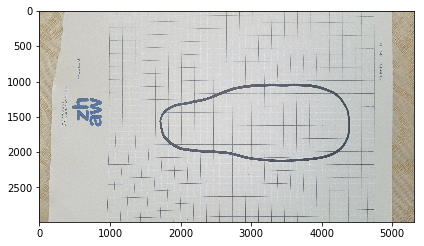

In [14]:
io.imshow(picture)
io.show()

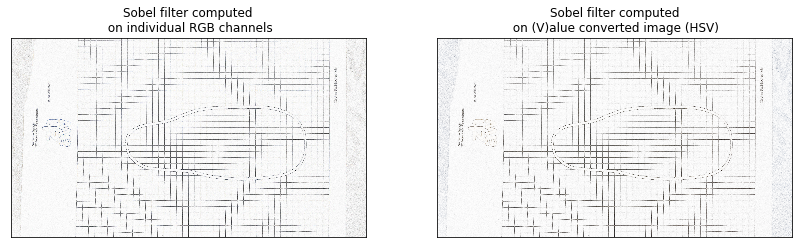

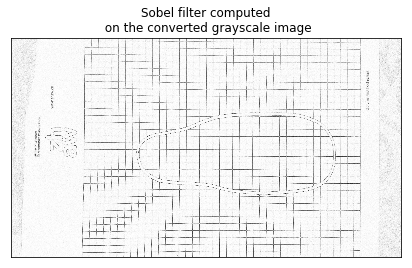

In [20]:
# converting to greyscale
# http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_adapt_rgb.html#sphx-glr-auto-examples-color-exposure-plot-adapt-rgb-py

from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters

@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)

@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


from skimage import data
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

image = picture

fig = plt.figure(figsize=(14, 7))
ax_each = fig.add_subplot(121, adjustable='box-forced')
ax_hsv = fig.add_subplot(122, sharex=ax_each, sharey=ax_each,
                         adjustable='box-forced')

# We use 1 - sobel_each(image)
# but this will not work if image is not normalized
ax_each.imshow(rescale_intensity(1 - sobel_each(image)))
ax_each.set_xticks([]), ax_each.set_yticks([])
ax_each.set_title("Sobel filter computed\n on individual RGB channels")

# We use 1 - sobel_hsv(image) but this will not work if image is not normalized
ax_hsv.imshow(rescale_intensity(1 - sobel_hsv(image)))
ax_hsv.set_xticks([]), ax_hsv.set_yticks([])
ax_hsv.set_title("Sobel filter computed\n on (V)alue converted image (HSV)")

######################################################################
# Notice that the result for the value-filtered image preserves the color of
# the original image, but channel filtered image combines in a more
# surprising way. In other common cases, smoothing for example, the channel
# filtered image will produce a better result than the value-filtered image.
#
# You can also create your own handler functions for ``adapt_rgb``. To do so,
# just create a function with the following signature::
#
#     def handler(image_filter, image, *args, **kwargs):
#         # Manipulate RGB image here...
#         image = image_filter(image, *args, **kwargs)
#         # Manipulate filtered image here...
#         return image
#
# Note that ``adapt_rgb`` handlers are written for filters where the image is
# the first argument.
#
# As a very simple example, we can just convert any RGB image to grayscale
# and then return the filtered result:

from skimage.color import rgb2gray


def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

######################################################################
# It's important to create a signature that uses ``*args`` and ``**kwargs``
# to pass arguments along to the filter so that the decorated function is
# allowed to have any number of positional and keyword arguments.
#
# Finally, we can use this handler with ``adapt_rgb`` just as before:


@adapt_rgb(as_gray)
def sobel_gray(image):
    return filters.sobel(image)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, sharex=ax_each, sharey=ax_each,
                     adjustable='box-forced')

# We use 1 - sobel_gray(image)
# but this will not work if image is not normalized
ax.imshow(rescale_intensity(1 - sobel_gray(image)), cmap=plt.cm.gray)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Sobel filter computed\n on the converted grayscale image")

plt.show()

In [22]:
grey_pig = rescale_intensity(1 - sobel_gray(image))

In [23]:
grey_pig.shape

(2988, 5312)

In [26]:
from skimage import img_as_float
from skimage.morphology import reconstruction
from scipy.ndimage import gaussian_filter

image = img_as_float(grey_pig)
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')

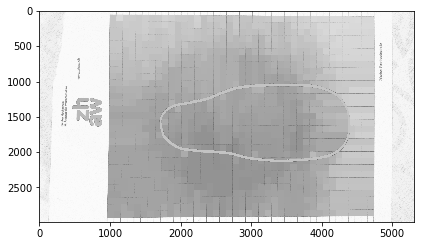

In [29]:
io.imshow(dilated)
io.show()

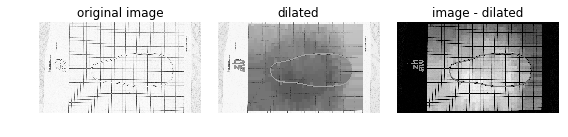

In [35]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(8, 2.5),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')
ax0.set_adjustable('box-forced')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')
ax1.set_adjustable('box-forced')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')
ax2.set_adjustable('box-forced')

fig.tight_layout()
plt.show()

In [36]:
dilated.shape

(2988, 5312)

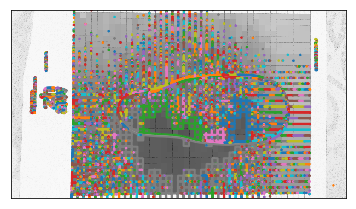

In [44]:
# finding contours
# http://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py
from skimage import measure

# Find contours at a constant value of 0.8
contours = measure.find_contours(dilated, 0.6)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(dilated, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

(2988, 5312)


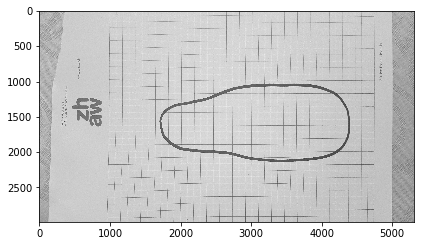

In [45]:
image_gray = rgb2gray(picture)
print(image_gray.shape)
io.imshow(image_gray)
io.show()

In [46]:
# next step: blob detection
# http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html#sphx-glr-auto-examples-features-detection-plot-blob-py
# or edge detection:
# http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html#sphx-glr-auto-examples-edges-plot-canny-py